In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
#from Fonctions_utils import f1_m, matrix_confusion
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
def matrix_confusion(y_test, y_pred):
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall



In [4]:
df_train = pd.read_csv("df_train_undersampling.csv")
df_val = pd.read_csv("df_val.csv")
df_test = pd.read_csv("df_test.csv")

In [5]:
sentences_train = df_train["text_clean"].values.astype(str)
sentences_val = df_val["text_clean"].values.astype(str)
sentences_test = df_test["text_clean"].values.astype(str)

y_train = np.array(df_train['Insult'])
y_val =np.array(df_val['Insult'])
y_test = np.array(df_test['Insult'])



In [6]:
tokenizer = Tokenizer(5000)
tokenizer.fit_on_texts(sentences_train)
train_sequences = tokenizer.texts_to_sequences(sentences_train)
test_sequences = tokenizer.texts_to_sequences(sentences_test)
val_sequences = tokenizer.texts_to_sequences(sentences_val)
max_sequence_length = max([len(seq) for seq in train_sequences + test_sequences])

train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length)
val_padded_sequences = pad_sequences(val_sequences, maxlen=max_sequence_length)

train_labels = y_train
test_labels = y_test
val_labels=y_val

# Build the NN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m,'accuracy'])
from tensorflow.keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_f1_m', mode=min,patience=3 )
# Train the model
history=model.fit(train_padded_sequences, train_labels, batch_size=128, epochs=10, validation_data=(test_padded_sequences, test_labels),callbacks=[es])


Epoch 1/10
12/12 [==============================] - 31s 2s/step - loss: 0.6904 - f1_m: 0.4612 - accuracy: 0.5731 - val_loss: 0.6811 - val_f1_m: 0.5174 - val_accuracy: 0.7518
Epoch 2/10
12/12 [==============================] - 31s 3s/step - loss: 0.6717 - f1_m: 0.6773 - accuracy: 0.6988 - val_loss: 0.6146 - val_f1_m: 0.3519 - val_accuracy: 0.7699
Epoch 3/10
12/12 [==============================] - 25s 2s/step - loss: 0.6029 - f1_m: 0.6944 - accuracy: 0.7418 - val_loss: 0.6222 - val_f1_m: 0.5864 - val_accuracy: 0.6615
Epoch 4/10
12/12 [==============================] - 30s 3s/step - loss: 0.4859 - f1_m: 0.8043 - accuracy: 0.7971 - val_loss: 0.5496 - val_f1_m: 0.6173 - val_accuracy: 0.7242
Epoch 5/10
12/12 [==============================] - 30s 3s/step - loss: 0.3576 - f1_m: 0.8657 - accuracy: 0.8613 - val_loss: 0.4348 - val_f1_m: 0.6459 - val_accuracy: 0.8024


In [7]:
y_predict_test = model.predict(val_padded_sequences)
y_predict_test2 = [round(item) for sublist in y_predict_test.tolist() for item in sublist]

38/38 [==============================] - 5s 122ms/step


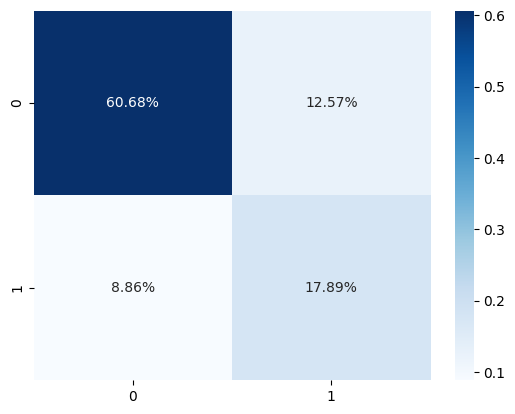

In [8]:

matrix_confusion(val_labels, y_predict_test2)

In [9]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

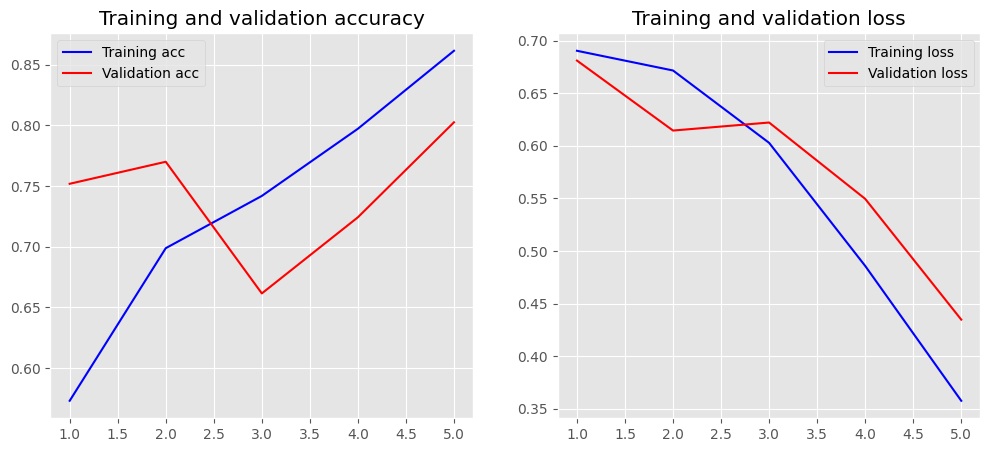

In [10]:
plot_history(history)

In [11]:
target_names = ['Neutre', 'Insultant']
print(classification_report(val_labels, y_predict_test2, target_names=target_names))

              precision    recall  f1-score   support

      Neutre       0.87      0.83      0.85       868
   Insultant       0.59      0.67      0.63       317

    accuracy                           0.79      1185
   macro avg       0.73      0.75      0.74      1185
weighted avg       0.80      0.79      0.79      1185

